# Google Analytics Customer Revenue Prediction


#### Objective of the competition:
We are challenged to analyze google merchandise store customer dataset to predict revenue per customer.
    

In [102]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [103]:
import pandas as pd
pd.__version__

'0.23.4'

* fullVisitorId unique user id
* channelGrouping channel via which user came to store
* date date of the visit
* device specifications for devide used to access store
* geoNetwork information about geography of user
* sessionId unique id of the visit
* socialEngagementType engagement type 
* totals aggregate values across sessions
* trafficSource traffic source from which the session originated
* visitId id for the session,this is only unique to user, for complete unique ID, use combination of fullVisitorId and visitId
* visitNumber the session number of this user, if this is the first session, then set to 1
* visitStartTime timestamp, expressed as POSIX time


In [104]:
def load_df(csv_path='./data/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
#         column_as_df = df[column].apply(lambda x: pd.Series(x))
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [105]:
# Read orig data and store into hdf format
%time train_orig = load_df()
%time test_orig = load_df('./data/test.csv')


Loaded train.csv. Shape: (903653, 55)
CPU times: user 2min 8s, sys: 1.84 s, total: 2min 10s
Wall time: 4min 44s
Loaded test.csv. Shape: (804684, 53)
CPU times: user 1min 41s, sys: 1.62 s, total: 1min 43s
Wall time: 1min 43s


In [106]:
train_df = train_orig
test_df = test_orig

In [107]:
# for df in (train_orig,test_orig):
# #     df['trafficSource.adwordsClickInfo.isVideoAd'] = df['trafficSource.adwordsClickInfo.isVideoAd'].fillna(True)
# #     print(df['trafficSource.adwordsClickInfo.isVideoAd'].unique())
#     feat = 'trafficSource.isTrueDirect'
#     df[feat] = df[feat].fillna(False)
#     print(df['trafficSource.isTrueDirect'].unique())
    

In [108]:
# %time train_orig.to_hdf('./data/train_df.orig.h5',key='train_df',format='table')
# %time test_orig.to_hdf('./data/test_df.orig.h5',key='test_df',format='table')

In [109]:
# Read in hdf format train and test
# %time train_df = load_df()
# %time test_df = load_df('./data/test.csv')

# %time train_df = pd.read_hdf('./data/train_df.orig.h5',key='train_df',format='table')
# %time test_df = pd.read_hdf('./data/test_df.orig.h5',key='test_df',format='table')

## Data Cleaning

In [110]:
# Check for missing values
check_miss = train_df.isnull().sum() / train_df.shape[0]
print(check_miss)
miss_feat = check_miss[check_miss.values!=0].index

channelGrouping                                      0.000000
date                                                 0.000000
fullVisitorId                                        0.000000
sessionId                                            0.000000
socialEngagementType                                 0.000000
visitId                                              0.000000
visitNumber                                          0.000000
visitStartTime                                       0.000000
device.browser                                       0.000000
device.browserSize                                   0.000000
device.browserVersion                                0.000000
device.deviceCategory                                0.000000
device.flashVersion                                  0.000000
device.isMobile                                      0.000000
device.language                                      0.000000
device.mobileDeviceBranding                          0.000000
device.m

In [111]:
to_drop = [
    'trafficSource.adContent',
    'trafficSource.adwordsClickInfo.adNetworkType',
    'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.isVideoAd',
    'trafficSource.adwordsClickInfo.page',
    'trafficSource.adwordsClickInfo.slot',
    'trafficSource.campaignCode',
    'trafficSource.referralPath'
]

def drop_col(df,to_drop):
    for col in to_drop:
        if col in df.columns:
            df.drop(col,axis=1,inplace=True)
# train_df['trafficSource.isTrueDirect'].unique()
# train_df['trafficSource.referralPath'].unique()
drop_col(train_df,to_drop)
drop_col(test_df,to_drop)

In [112]:
# Check for missing values
check_miss = train_df.isnull().sum() / train_df.shape[0]
print(check_miss)
miss_feat = check_miss[check_miss.values!=0].index

channelGrouping                                      0.000000
date                                                 0.000000
fullVisitorId                                        0.000000
sessionId                                            0.000000
socialEngagementType                                 0.000000
visitId                                              0.000000
visitNumber                                          0.000000
visitStartTime                                       0.000000
device.browser                                       0.000000
device.browserSize                                   0.000000
device.browserVersion                                0.000000
device.deviceCategory                                0.000000
device.flashVersion                                  0.000000
device.isMobile                                      0.000000
device.language                                      0.000000
device.mobileDeviceBranding                          0.000000
device.m

In [113]:
for df in (train_df,test_df):
#     df['totals.bounces'] = df['totals.bounces'].fillna(0).astype(int)
    feat = 'totals.newVisits'
    df[feat] = df[feat].fillna(0).astype(int)
    feat = 'totals.pageviews'
    df[feat] = df[feat].fillna(0).astype(int)
    feat = 'trafficSource.isTrueDirect'
    df[feat] = df[feat].fillna(True).astype(bool)

# just for train
feat = 'totals.transactionRevenue'
train_df[feat] = train_df[feat].fillna(0.0).astype(float)



for col in miss_feat:
    print("-------------------> ",col)
    print(train_df[col].unique())
#     print(type(train_df[col]))
    print(train_df[col].dtypes)
    print(train_df[col].isnull().sum()/train_df.shape[0])




------------------->  totals.bounces
['1' nan]
object
0.5013240701906595
------------------->  totals.newVisits
[1 0]
int64
0.0
------------------->  totals.pageviews
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  20  19  21  25  22  26  23  24  30  27  29  28  32  31  34  33  38  35
  40  36  37  39  43  45  47  52  44  50  46  49  51  56  59  71  57  82
  84  92  90  41  79 138  48  69 112  42  65  60  63  68  58  74 165  53
  54  55  61  70  80  78  72 188  73  62  75  86 197 148  67 102  64 103
 144   0  81 119 104 128  87 111  66  83 135  94  91  99  77 118 202 127
  93 106 155 117  76  89  85 143 105 115  95 110 137 120 116 208 126 400
 101 108 333  97  96  98 125 113 327 154 121 183 123 141 224  88 195 343
 156 193 100 150 122 145 174 147 131 169 164 249 114 189 223 124 139 341
 469 309 162 146 270 107 153 233 161 179 129 220 191 323 431 351 132 305
 175 130 166 185 245 219 167 173 109 133 149 136 168 358 466 182 340 215
 142 275 134 196 324 300 190 1

In [114]:
#check for type
# train_df.info()
# train_df.isnull().sum()
test_df.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserSize                                        0
device.browserVersion                                     0
device.deviceCategory                                     0
device.flashVersion                                       0
device.isMobile                                           0
device.language                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceInfo                 

In [115]:
# deal with keyworkds
# test_df['trafficSource.keyword']
# print(train_df['trafficSource.keyword'].groupby('trafficSource.keyword').count())
def clean_keys(tag):
   
    tag = str(tag).lower()
    simple_keys = {'google':'google',
                   'youtube':'youtube',
                   'tub':'youtube',
                   'you':'youtube',
                   'goog':'google',
                   'yu':'youtube',
                   'content targeting':'content targeting',
                   'shirt':'tshirt',
                   'android':'android',
                   'bottle':'bottle',
                   'ube':'youtube',
                   'gle':'google',
                   '谷歌':'google'
                   
                   
                  }
    for key,value in simple_keys.items():
        if key in tag:
            return value
    return tag    
feat = 'trafficSource.keyword'        
train_df[feat] = train_df[feat].apply(lambda x: clean_keys(x))
test_df[feat] = test_df[feat].apply(lambda x: clean_keys(x))

In [116]:
key_freq = train_df.groupby('trafficSource.keyword')['trafficSource.keyword'].count().sort_values(ascending=False)
key_freq

trafficSource.keyword
nan                                       502929
(not provided)                            366363
6qehscssdk0z36ri                           11503
google                                     11094
youtube                                     4061
content targeting                           2597
1hzbaqlcbjwfgoh7                            2264
(user vertical targeting)                    489
1x4me6zknv0zg-jv                             467
(automatic matching)                         427
tshirt                                       293
arts & entertainment                         126
android                                       65
bag                                           58
merchandise                                   42
category_l1==166                              36
bottle                                        25
merchandise store                             21
category_l1==222                              19
apparel                                       1

In [117]:
# Check for Datatype
# train_df.info()
# train_df['trafficSource.keyword']
# train_df.groupby('trafficSource.keyword')['trafficSource.keyword'] 
# key_freq = train_df.groupby('trafficSource.keyword')['trafficSource.keyword'].count().sort_values(ascending=False)[:100]
def combine_less_freq_key(tag):
    tag = str(tag)
    tag_freq = int(key_freq[tag])
    if tag_freq < 7:
        return 'others'
    else:
        return tag
#     return tag_freq
# combine_less_freq_key('gooogl')

def clean_keys(df):
    df['trafficSource.keyword'] =  df['trafficSource.keyword'].fillna('(not provided)')
#     df['trafficSource.keyword'] = df['trafficSource.keyword'].apply(lambda x: combine_less_freq_key(x))
# train_df['trafficSource.keyword']
    
clean_keys(train_df)
clean_keys(test_df)
# train_df['trafficSource.keyword'].has(['pink hood'])

In [118]:
# Deal with visitStartTime
from sklearn.feature_extraction import DictVectorizer
from datetime import datetime

for df in (train_df,test_df):
    df['year'] = df['visitStartTime'].apply(lambda x : 
                                            datetime.utcfromtimestamp(x).strftime("%Y"))
    df['month'] = df['visitStartTime'].apply(lambda x : 
                                            datetime.utcfromtimestamp(x).strftime("%m"))
    df['day'] = df['visitStartTime'].apply(lambda x : 
                                            datetime.utcfromtimestamp(x).strftime("%d"))
    df['hour'] = df['visitStartTime'].apply(lambda x : 
                                            datetime.utcfromtimestamp(x).strftime("%H"))
    df['day_week'] = df['visitStartTime'].apply(lambda x : 
                                            datetime.utcfromtimestamp(x).strftime("%w"))
    df['am_pm'] = df['visitStartTime'].apply(lambda x : 
                                            datetime.utcfromtimestamp(x).strftime("%p"))
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [119]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 53 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

In [120]:
test_df['socialEngagementType'].unique()

array(['Not Socially Engaged'], dtype=object)

In [121]:
# For each feature, we check the unique values /statistics

def check_df(df):
    for col in df.columns:
        print("--------------------> col : ", col )
        print(df[col].unique())
        
        
check_df(train_df)

--------------------> col :  channelGrouping
['Organic Search' 'Referral' 'Paid Search' 'Affiliates' 'Direct' 'Display'
 'Social' '(Other)']
--------------------> col :  date
[20160902 20170126 20170623 20170312 20170203 20160811 20170613 20170113
 20161118 20161110 20161112 20170621 20161123 20170501 20170611 20170630
 20161213 20170519 20170111 20170624 20161014 20170529 20170515 20170420
 20160831 20170801 20170228 20161209 20160917 20170617 20161216 20160820
 20170616 20160822 20161129 20170318 20161130 20170303 20160816 20161030
 20161230 20170704 20170213 20170511 20160912 20161022 20160824 20170421
 20170412 20160805 20161018 20170310 20170428 20170116 20170115 20170102
 20170320 20170410 20161125 20170311 20170622 20170329 20161026 20170308
 20161124 20161021 20170217 20170627 20161117 20161109 20160819 20161128
 20160901 20161122 20170615 20170714 20160915 20170606 20161107 20160929
 20160821 20160803 20170321 20170128 20160906 20170724 20161208 20170118
 20161020 20170121 201

['not available in demo dataset']
--------------------> col :  geoNetwork.continent
['Asia' 'Oceania' 'Europe' 'Americas' 'Africa' '(not set)']
--------------------> col :  geoNetwork.country
['Turkey' 'Australia' 'Spain' 'Indonesia' 'United Kingdom' 'Italy'
 'Pakistan' 'Austria' 'Netherlands' 'India' 'France' 'Brazil' 'China'
 'Singapore' 'Argentina' 'Poland' 'Germany' 'Canada' 'Thailand' 'Hungary'
 'Malaysia' 'Denmark' 'Taiwan' 'Russia' 'Nigeria' 'Belgium' 'South Korea'
 'Chile' 'Ireland' 'Philippines' 'Greece' 'Mexico' 'Montenegro'
 'United States' 'Bangladesh' 'Japan' 'Slovenia' 'Czechia' 'Sweden'
 'United Arab Emirates' 'Switzerland' 'Portugal' 'Peru' 'Hong Kong'
 'Vietnam' 'Sri Lanka' 'Serbia' 'Norway' 'Romania' 'Kenya' 'Ukraine'
 'Israel' 'Slovakia' '(not set)' 'Lithuania' 'Puerto Rico'
 'Bosnia & Herzegovina' 'Croatia' 'South Africa' 'Paraguay' 'Botswana'
 'Colombia' 'Uruguay' 'Algeria' 'Finland' 'Guatemala' 'Egypt' 'Malta'
 'Bulgaria' 'New Zealand' 'Kuwait' 'Uzbekistan' 'Saudi

['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '41' '42' '43' '44' '45'
 '46' '47' '48' '49' '50' '51' '52' '54' '55' '57' '65' '67' '72' '74'
 '79' '82' '83' '92' '103' '109' '134' '143' '144' '66' '73' '112' '189'
 '62' '63' '81' '91' '102' '161' '40' '86' '99' '61' '69' '80' '89' '100'
 '53' '56' '58' '71' '76' '77' '95' '229' '60' '64' '68' '85' '94' '96'
 '107' '110' '113' '147' '331' '108' '59' '70' '98' '119' '303' '218'
 '146' '75' '78' '93' '101' '149' '106' '114' '156' '138' '141' '175' '88'
 '97' '115' '90' '183' '227' '87' '126' '148' '130' '176' '84' '202' '121'
 '122' '207' '140' '193' '302' '142' '105' '116' '196' '111' '201' '133'
 '159' '117' '131' '150' '168' '311' '249' '127' '137' '500' '155' '118'
 '125' '139' '154' '123' '124' '104' '162' '167' '170' '132' '136' '151'
 '166' '187' '279' '328' '174' '386' '282' '286' '220' '1

['organic' 'referral' 'cpc' 'affiliate' '(none)' 'cpm' '(not set)']
--------------------> col :  trafficSource.source
['google' 'baidu' 'googleweblight.com' 'sites.google.com' 'bing'
 'siliconvalley.about.com' 'analytics.google.com' 'Partners' '(direct)'
 'mall.googleplex.com' 'google.com' 'google.co.in' 'qiita.com' 'google.pl'
 'mail.google.com' 'hangouts.google.com' 'dealspotr.com'
 'optimize.google.com' 'arstechnica.com' 'dfa' 'docs.google.com'
 'sashihara.jp' 'google.gatewaycdi.com' 'phandroid.com' 'images.google'
 'youtube.com' 'l.facebook.com' 'facebook.com' 'quora.com'
 'm.facebook.com' 'reddit.com' 'google.co.jp' 'aol' 'moma.corp.google.com'
 'blog.golang.org' 'yahoo' 't.co' 'nordic.businessinsider.com'
 'duckduckgo.com' 'm.baidu.com' 'tpc.googlesyndication.com'
 'googleads.g.doubleclick.net'
 '0.shared.bow.cat2.ads-bow.vu.borg.google.com:9856' 'online-metrics.com'
 'cv.il3.ub.edu' 'gophergala.com' 'plus.google.com' 's0.2mdn.net'
 'keep.google.com' 'svirkar.mtv.corp.google.com:

['09' '01' '06' '03' '02' '08' '11' '05' '07' '12' '10' '04']
--------------------> col :  day
['02' '03' '26' '27' '23' '24' '12' '13' '04' '11' '14' '18' '19' '10'
 '21' '22' '01' '30' '20' '25' '15' '29' '16' '31' '28' '09' '17' '05'
 '06' '08' '07']
--------------------> col :  hour
['15' '05' '01' '13' '09' '11' '10' '08' '16' '20' '18' '02' '07' '14'
 '22' '00' '03' '06' '17' '04' '12' '19' '21' '23']
--------------------> col :  day_week
['5' '6' '4' '0' '1' '2' '3']
--------------------> col :  am_pm
['PM' 'AM']


In [122]:
cat_feat = ['channelGrouping',
            'device.browser', 
            'device.operatingSystem', 
            'geoNetwork.continent',
            'geoNetwork.country',
            'geoNetwork.subContinent',
            'trafficSource.campaign', 
            'trafficSource.keyword', 
            'trafficSource.medium', 
            'year', 
            'month', 
            'day', 
            'hour',
            'am_pm']
feat_should_drop = ['date',
                    'sessionId',
                    'socialEngagementType', 
                    'visitId', 
                    'visitStartTime', 'device.browserSize',
                    'device.browserVersion', 
                    'device.deviceCategory', 
                    'device.flashVersion', 
                    'device.language', 
                    'device.mobileDeviceBranding', 
                    'device.mobileDeviceInfo', 
                    'device.mobileDeviceMarketingName', 
                    'device.mobileDeviceModel', 
                    'device.mobileInputSelector', 
                    'device.operatingSystemVersion', 
                    'device.screenColors',
                    'device.screenResolution', 
                    'geoNetwork.cityId', 
                    'geoNetwork.latitude',
                    'geoNetwork.longitude', 
                    'geoNetwork.networkLocation', 
                    'geoNetwork.networkLocation', 
                    'totals.visits', 
                    'trafficSource.adwordsClickInfo.criteriaParameters', 
                    'trafficSource.isTrueDirect']

In [123]:
def drop_col(df,to_drop):
    for col in to_drop:
        if col in df.columns:
            df.drop(col,axis=1,inplace=True)
            
drop_col(train_df,feat_should_drop)
drop_col(test_df,feat_should_drop)

In [124]:
print(train_df.columns)
print(test_df.columns)
print(train_df.shape)
print(test_df.shape)

Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'device.browser',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.campaign', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.source', 'year', 'month', 'day',
       'hour', 'day_week', 'am_pm'],
      dtype='object')
Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'device.browser',
       'device.isMobile', 'device.operatingSystem', 'geoNetwork.city',
       'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pagevie

### Target Varable Exploration
Sum up transaction revenue at user level and take a log and then do a scatter plot

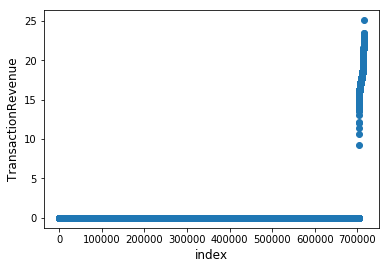

In [125]:
train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype('float')
gdf = train_df.groupby('fullVisitorId')['totals.transactionRevenue'].sum().reset_index()

plt.figure()
plt.scatter(range(gdf.shape[0]),
           np.sort( np.log1p(gdf['totals.transactionRevenue'].values))
           )
plt.xlabel('index',fontsize=12)
plt.ylabel('TransactionRevenue',fontsize=12)
plt.show()

In [126]:
nzi = pd.notnull(train_df['totals.transactionRevenue']).sum()
nzr = (gdf['totals.transactionRevenue']>0).sum()
print(" Number of instance in train set with non-zero:",nzi,"and ratio is:",nzi/train_df.shape[0])
print(" Number of unique user in train with non-zero:", nzr,"and ratio is:",nzr/gdf.shape[0])

 Number of instance in train set with non-zero: 903653 and ratio is: 1.0
 Number of unique user in train with non-zero: 9996 and ratio is: 0.013996726255903731


### number of visitor and common visitor

In [127]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in test set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

Number of unique visitors in train set :  714167  out of rows :  903653
Number of unique visitors in test set :  617242  out of rows :  804684
Number of common visitors in train and test set :  7679


In [128]:
# # Remove constant values
# const_cols = [c for c in train_df.columns if train_df[c].nunique(dropna=False) == 1]

In [129]:
# fullVisitorId
target = 'totals.transactionRevenue'

# 1. some visitor visited more then once, and they are more likely to buy items
# add another column, the number of times the this visitor visited the store
def check_visit_id(df):
    feat = 'fullVisitorId'
    visit_freq = df.groupby(feat)[feat].count()
    def fun1(x):
        return visit_freq[x]
    df['visitFreq'] = df[feat].apply(lambda x:fun1(x))
check_visit_id(train_df)
check_visit_id(test_df)

# train_df['visitFreq']        

# 2. for visitor who bought items, it is more likely to buy again
# add another column, 1 if visitor bough anything, 0 if not
def check_visit_revenue(df):
    feat = 'fullVisitorId'
    visitor_revenue = train_df.groupby(feat)[target].sum()
    def fun2(x):
        if x not in visitor_revenue.index:
            return 0
        revenue = visitor_revenue[x]
        if revenue == 0:
            return 0
        else:
            return 1
    df['RichGuys'] = df[feat].apply(lambda x: fun2(x))
check_visit_revenue(train_df)
check_visit_revenue(test_df)
# fil = train_df[target] > 0
# train_df[fil][['fullVisitorId',target,'RichGuys']]
# train_df['RichGuys']
# 3. drop this column
# for df in (test_df,train_df):
#     df.drop('fullVisitorId',axis=1,inplace=True)




In [130]:
# train_df['RichGuys']

 -----> totoal size of current feature is: 54


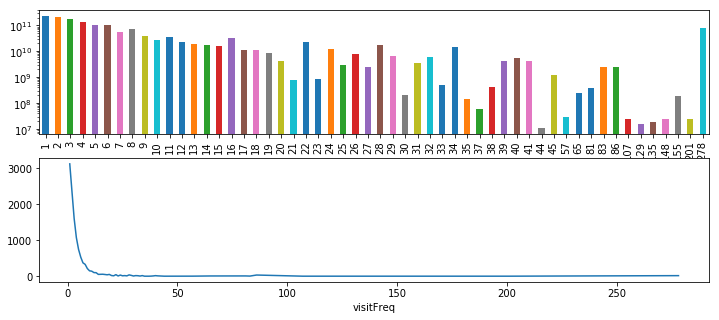

In [131]:
# Check relationship between the two new columns I just created
def check_me(feat):
    target='totals.transactionRevenue'
#     print(train_df[feat]
    # two plots needed for non-zero revenue cases
    # 1. plot of relationship between feature and target, we only show the top 10
    # 2. plot the frequency of each dimension of current feature, based on the same 10 
    # categories we show in #1
    no_zero_df = train_df[train_df[target] > 0]
    fig,(ax1,ax2) = plt.subplots(2,1)
    no_zero_df.groupby(feat)[target].sum().plot(x=feat,y=target,kind='bar',logy=True,figsize=(12,5)
                                   ,ax=ax1 )
    no_zero_df.groupby(feat)[feat].count().plot(ax=ax2)
    print(" -----> totoal size of current feature is:",no_zero_df.groupby(feat)[feat].size().shape[0])
    
#     train_df.plot(x=feat,y=target)
#     train_df[[feat,target]].plot()
#     plt.show()
    
#     plt.xlabel(feat,fontsize=16)
#     plt.ylabel(target,fontsize=17)
    
check_me('visitFreq')


In [132]:
# visitFreq 
# train_df['visitFreq'].hist()
# we divide the visitFreq into differnt sections with cut 
# bins = [0,5,10,15,20,25,30,35,45,300]
# bins_flag = [1,2,3,4,5,6,7,8,9]
# for df in (train_df,test_df):
#     df['visitFreq_flag'] = pd.qcut(df['visitFreq'],bins=bins,labels=bins_flag)
#     print(df['visitFreq_flag'])
# dd = np.log(np.log(train_df['visitFreq'])+1)
# dd.hist()
# from scipy.stats import skew
# print(skew(train_df['visitFreq'],axis=0))
# dd = (train_df['visitFreq'])
# dd.hist()

# plt.hist(np.log(train_df[target]+1))

In [133]:
# We keep totals.hits as it is

In [134]:
# # visitNumber 
# feat = 'visitNumber'
# # check_me(feat)
# # train_df[['fullVisitorId','visitNumber','visitFreq']]
# # train_df['fullVisitorId']
# for df in (test_df,train_df):
#     df.drop(feat,axis=1,inplace=True)
# check_me('visitNumber')
# df[]

 -----> totoal size of current feature is: 134


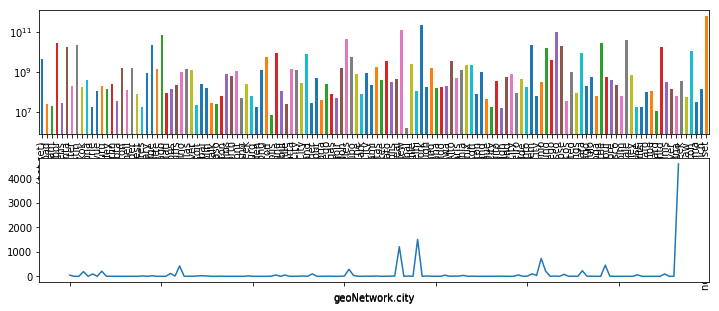

In [135]:
# geoNetwork.city
feat = 'geoNetwork.city'
check_me(feat)

 -----> totoal size of current feature is: 46


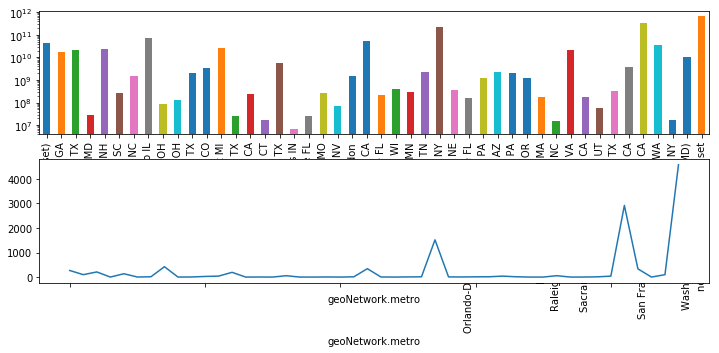

In [136]:
# geoNetwork.metro
check_me('geoNetwork.metro')

 -----> totoal size of current feature is: 732


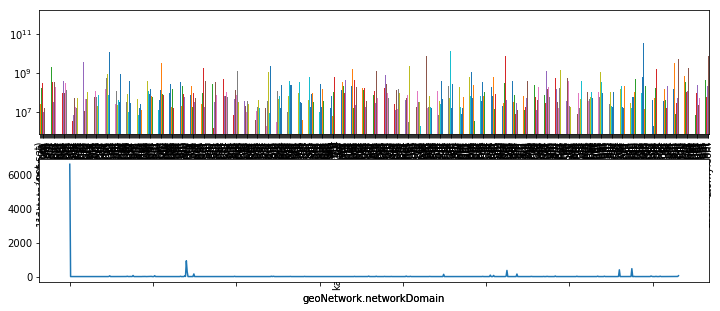

In [137]:
# geoNetwork.networkDomain
# check_me('geoNetwork.networkDomain')

check_me('geoNetwork.networkDomain')

In [138]:
feat = 'geoNetwork.networkDomain'
new_count = train_df.groupby(feat)[feat].count()
new_count.sort_values(ascending=False)[:300]


geoNetwork.networkDomain
(not set)                  244881
unknown.unknown            146034
comcast.net                 28743
rr.com                      14827
verizon.net                 13637
ttnet.com.tr                13228
comcastbusiness.net          9985
hinet.net                    7919
virginm.net                  6414
3bb.co.th                    6046
prod-infinitum.com.mx        5960
cox.net                      5812
sbcglobal.net                5388
btcentralplus.com            5304
att.net                      5230
google.com                   5035
optonline.net                4972
totbb.net                    4895
vnpt.vn                      4508
asianet.co.th                4374
pldt.net                     4008
rima-tde.net                 3963
amazonaws.com                3769
t-ipconnect.de               3656
telecomitalia.it             3571
qwest.net                    3534
airtelbroadband.in           3389
virtua.com.br                3318
bell.ca                

In [139]:
# replace dot with space in feature geonetwork
feat = 'geoNetwork.networkDomain'
for df in (test_df,train_df):
    print("--->")
    df[feat] = df[feat].apply(lambda x:x.replace('.',' '))
    

--->
--->


In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
# Use tfidfVectorizer to extract feature
Tvect = TfidfVectorizer(ngram_range=(1,2),max_features=20000)
vect = Tvect.fit(train_df[feat])


In [141]:
train_vect = vect.transform(train_df[feat])
test_vect = vect.transform(test_df[feat])

In [142]:
# dimension reduction on extracted feature
svd = TruncatedSVD(n_components=10)

vect_cols = ['vect'+str(x) for x in range(1,11)]

In [143]:
df_train_vect = pd.DataFrame(svd.fit_transform(train_vect),columns=vect_cols)
df_test_vect = pd.DataFrame(svd.fit_transform(test_vect),columns=vect_cols)

In [144]:
df_train_vect.shape

(903653, 10)

In [145]:
train_df = pd.concat([train_df,df_train_vect],axis=1)
test_df = pd.concat([test_df,df_test_vect],axis=1)

 -----> totoal size of current feature is: 79


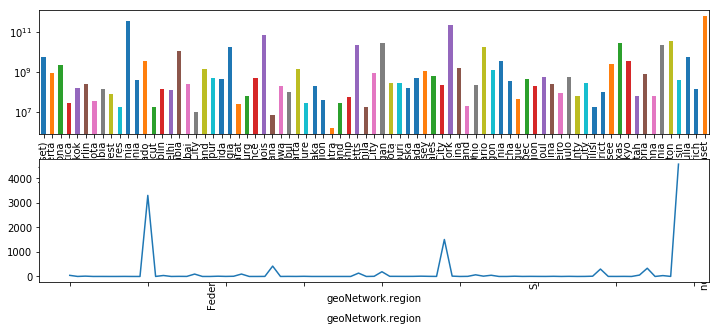

In [146]:
# geoNetwork.region
check_me('geoNetwork.region')
# train_df.groupby('geoNetwork.region')['geoNetwork.region'].count()

In [147]:
# check_me('totals.pageviews')
# log_view = train_df

In [148]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    #vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [149]:
# feat = 'totals.transactionRevenue'
# print(feat)
# # check_me('totals.transactionRevenue')

In [150]:
# trafficSource.source
feat = 'trafficSource.source'
train_df.groupby(feat)[feat].count().sort_values(ascending=False)

trafficSource.source
google                          400788
youtube.com                     212602
(direct)                        143028
mall.googleplex.com              66416
Partners                         16411
analytics.google.com             16172
dfa                               5686
google.com                        4669
m.facebook.com                    3365
baidu                             3356
sites.google.com                  2983
facebook.com                      2296
siliconvalley.about.com           2097
reddit.com                        2022
qiita.com                         1813
quora.com                         1546
bing                              1530
t.co                              1529
yahoo                             1480
mail.google.com                   1457
gdeals.googleplex.com             1063
groups.google.com                 1025
l.facebook.com                     795
blog.golang.org                    742
dealspotr.com                      528
plus

In [151]:
# clean source
def clean_keys(tag):
   
    tag = str(tag).lower()
    simple_keys = {'google':'google',
                   'youtube':'youtube',
                   'tub':'youtube',
                   'you':'youtube',
                   'goog':'google',
                   'yu':'youtube',
                   'content targeting':'content targeting',
                   'shirt':'tshirt',
                   'android':'android',
                   'bottle':'bottle',
                   'ube':'youtube',
                   'gle':'google',
                   '谷歌':'google',
                   'yahoo':'yahoo',
                   'redd':'reddit',
                   'twit':'twitter',
                   'face':'facebook',
                   'tumb':'tumblr',
                   'what':'whatsapp',
                   'pint':'pinterest',
                   'meet':'meetup',
                   'baidu':'baidu',
                   'quora':'quora',
                   'bing':'bing'
                          
                   
                  }
    for key,value in simple_keys.items():
        if key in tag:
            return value
    return tag

feat = 'trafficSource.source'
train_df[feat] = train_df[feat].apply(lambda x:clean_keys(x))
test_df[feat] = test_df[feat].apply(lambda x:clean_keys(x))
# print(train_df.groupby(feat)[feat].count().shape)


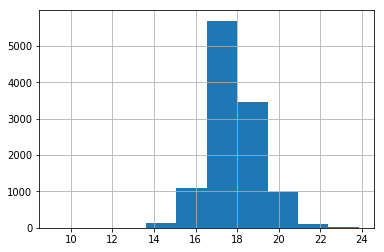

In [152]:
# Totalrevenue should be log transformed
feat = 'totals.transactionRevenue'
# non_zero = np.log1p(train_df[train_df[feat] != 0][feat])
# non_zero.hist(bins=100)
# non_zero[feat]
train_df[feat] = np.log1p(train_df[feat])
train_df[train_df[feat]!=0][feat].hist()

In [153]:
def check_meta_df(df):
    target='totals.transactionRevenue'
    # this function prints the meta info that I would like to see for each feature
    meta_feat = ['type','uniqueCount','q01count','q05count','min','max','mean']
    meta = pd.DataFrame(columns=meta_feat)
    for index,col_name in enumerate(df.columns):
        col = df[col_name]
#         print('--> on: ',col_name)
        meta.at[col_name,'type'] = col.dtypes
        meta.at[col_name,'uniqueCount'] = col.unique().shape[0]

        freq = df.groupby(col_name)[col_name].count() / df.shape[0]
        meta.at[col_name,'q01count'] = (freq < 0.001).sum() / freq.shape[0]
        meta.at[col_name,'q05count'] = (freq < 0.005).sum() / freq.shape[0]
        if 'float' in str(df[col_name].dtype) or 'int' in str(df[col_name].dtype):
            meta.at[col_name,'min'] = col.min()
            meta.at[col_name,'max'] = col.max()
            meta.at[col_name,'mean'] = col.mean()
            meta.at[col_name,'skewness'] = col.skew()
            
            
    print(meta)
check_meta_df(train_df)

                              type uniqueCount  q01count  q05count  \
channelGrouping             object           8     0.125     0.125   
fullVisitorId               object      714167         1         1   
visitNumber                  int64         384  0.960938  0.981771   
device.browser              object          54  0.796296  0.833333   
device.isMobile               bool           2         0         0   
device.operatingSystem      object          20       0.6      0.65   
geoNetwork.city             object         649  0.887519  0.970724   
geoNetwork.continent        object           6         0  0.166667   
geoNetwork.country          object         222  0.698198  0.851351   
geoNetwork.metro            object          94  0.797872  0.914894   
geoNetwork.networkDomain    object       28064  0.997078  0.999359   
geoNetwork.region           object         376  0.837766  0.949468   
geoNetwork.subContinent     object          23  0.173913  0.434783   
totals.bounces      

In [154]:
# combine small freq features together

combine_small_features_list = [
    'geoNetwork.city',
    'geoNetwork.region',
    'trafficSource.keyword',
    'trafficSource.source'
]
# for df in (train_df,test_df):
#     df['visitNumber'] = df['visitNumber'].astype('str')
#     df['visitFreq'] = df['visitNumber'].astype('str')

def combine_small_freq_feat(df,feat_list):
    
    for feat in feat_list:
        print("---> working on: ",feat)
        freq = df.groupby(feat)[feat].count() / df.shape[0]
        
        
        def get_new_flag(x):
            if freq[x] < 0.001:
                    return 'others'
            else:
                return x
        df[feat] = df[feat].apply(lambda x:get_new_flag(x))
#         print(freq[1])
combine_small_freq_feat(train_df,combine_small_features_list)
combine_small_freq_feat(test_df,combine_small_features_list)

---> working on:  geoNetwork.city
---> working on:  geoNetwork.region
---> working on:  trafficSource.keyword
---> working on:  trafficSource.source
---> working on:  geoNetwork.city
---> working on:  geoNetwork.region
---> working on:  trafficSource.keyword
---> working on:  trafficSource.source


In [155]:
# train_df['geoNetwork.city']

In [156]:
# 1. Define featuers to use one-hot encoding
# 2. Define features to use labelencoder
# 3. Define features to drop 

cat_list = []
for col in train_df.columns:
    if 'float' in str(train_df[col].dtypes) or 'int' in str(train_df[col].dtypes):
        print("skip:",col)
    else:
        cat_list.append(col)
cat_list = [x for x in cat_list if x not in ['fullVisitorId']]        

print(cat_list)
# implement encoding to these features
for col in cat_list:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform( list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform( list( test_df[col].values.astype('str')))
    




skip: visitNumber
skip: totals.newVisits
skip: totals.pageviews
skip: totals.transactionRevenue
skip: visitFreq
skip: RichGuys
skip: vect1
skip: vect2
skip: vect3
skip: vect4
skip: vect5
skip: vect6
skip: vect7
skip: vect8
skip: vect9
skip: vect10
['channelGrouping', 'device.browser', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces', 'totals.hits', 'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.source', 'year', 'month', 'day', 'hour', 'day_week', 'am_pm']
channelGrouping
device.browser
device.isMobile
device.operatingSystem
geoNetwork.city
geoNetwork.continent
geoNetwork.country
geoNetwork.metro
geoNetwork.networkDomain
geoNetwork.region
geoNetwork.subContinent
totals.bounces
totals.hits
trafficSource.campaign
trafficSource.keyword
trafficSource.medium
trafficSource.source

In [157]:
# train_df['year']

In [158]:
# ## Part2. 4 check for correlation between different features
# # # get Pearson Correlation of Features
# def correlation_heatmap(df):
#     _ , ax = plt.subplots(figsize =(14, 12))
#     colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
#     _ = sns.heatmap(
#         df.corr(), 
#         cmap = colormap,
#         square=True, 
#         cbar_kws={'shrink':.9 }, 
#         ax=ax,
#         annot=True, 
#         linewidths=0.1,vmax=1.0, linecolor='white',
#         annot_kws={'fontsize':12 }
#     )
# plt.title("Pearson Correlation of Features",y=1.05,size=15)
# correlation_heatmap(data)


In [159]:
# Define features that have too many values and 
# we combines those with frequency less then 1000 together


In [160]:
to_drop = [
    'geoNetwork.networkDomain'
    
]

In [161]:
# output to hdf format
output_col = [x for x in train_df.columns if x not in to_drop]
train_out = train_df[output_col]
output_col = [x for x in test_df.columns if x not in to_drop]
test_out = test_df[output_col]

%time train_df.to_hdf('./data/train_df.h5',key='train_df',format='table')
%time test_df.to_hdf('./data/test_df.h5',key='test_df',format='table')

CPU times: user 1.42 s, sys: 176 ms, total: 1.6 s
Wall time: 1.63 s
CPU times: user 1.24 s, sys: 140 ms, total: 1.38 s
Wall time: 1.46 s


In [162]:
train_out.shape

(903653, 39)

In [163]:
train_out

,channelGrouping,fullVisitorId,visitNumber,device.browser,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.source,year,month,day,hour,day_week,am_pm,visitFreq,RichGuys,vect1,vect2,vect3,vect4,vect5,vect6,vect7,vect8,vect9,vect10
0,4,1131660440785968503,1,35,0,20,36,3,210,0,36,21,0,0,1,1,0.0,4,1,5,5,0,8,1,15,5,1,1,0,1.375435e-11,1.568493e-05,4.551282e-04,5.171336e-01,-2.222089e-03,7.905641e-01,-4.868576e-03,-3.248714e-01,2.973205e-03,9.611619e-03
1,4,377306020877927890,1,43,0,7,90,5,12,122,79,1,0,0,1,1,0.0,4,1,5,5,0,8,2,5,6,0,1,0,2.238431e-11,1.449060e-06,9.230638e-02,5.989568e-03,8.317452e-02,3.581651e-04,5.304998e-02,1.236867e-02,5.250822e-03,4.309257e-02
2,4,3895546263509774583,1,35,0,20,49,4,185,0,17,19,0,0,1,1,0.0,4,1,5,5,0,8,2,1,6,0,1,0,4.732306e-12,1.000000e+00,-2.767014e-06,-4.458055e-05,-1.972377e-06,-1.506540e-06,-1.387111e-06,-2.444756e-05,-3.152992e-08,1.317677e-07
3,4,4763447161404445595,1,79,0,6,90,3,94,122,79,16,0,0,1,1,0.0,4,7,5,5,0,8,2,5,6,0,1,0,4.732309e-12,1.000000e+00,-2.767014e-06,-4.458055e-05,-1.972387e-06,-1.506541e-06,-1.387116e-06,-2.444756e-05,-3.153042e-08,1.317653e-07
4,4,27294437909732085,2,35,1,1,90,4,217,122,79,13,0,0,0,1,0.0,4,1,5,5,0,8,1,13,5,1,2,0,4.732311e-12,1.000000e+00,-2.767014e-06,-4.458055e-05,-1.972393e-06,-1.506544e-06,-1.387112e-06,-2.444755e-05,-3.153204e-08,1.317648e-07
5,4,2938943183656635653,1,35,0,20,90,4,100,122,79,19,0,0,1,1,0.0,4,1,5,5,0,8,1,9,5,0,1,0,-2.208827e-10,1.193230e-06,7.709583e-06,6.908816e-05,2.119770e-04,-1.819475e-04,-2.296025e-03,4.235327e-04,3.910026e-03,-5.027495e-03
6,4,1905672039242460897,1,35,0,20,90,3,154,122,79,18,0,0,1,1,0.0,4,1,5,5,0,8,1,11,5,0,1,0,4.732308e-12,1.000000e+00,-2.767014e-06,-4.458055e-05,-1.972384e-06,-1.506537e-06,-1.387116e-06,-2.444756e-05,-3.152669e-08,1.317641e-07
7,4,537222803633850821,1,35,0,20,91,5,12,0,80,1,0,0,1,1,0.0,4,1,5,5,0,8,1,10,5,0,1,0,3.408525e-11,1.623967e-06,1.049764e-01,6.891593e-03,9.654268e-02,3.969851e-04,6.276980e-02,1.483087e-02,6.144803e-03,5.195239e-02
8,4,4445454811831400414,1,47,0,20,90,4,13,122,79,22,0,0,1,1,0.0,4,1,5,5,0,8,1,8,5,0,1,0,-4.853022e-15,1.819262e-10,1.278569e-06,3.193244e-06,2.638185e-06,-1.417015e-07,6.391550e-06,3.532001e-06,7.716664e-05,1.792478e-06
9,4,9499785259412240342,1,43,0,20,90,4,144,122,79,22,0,0,1,1,0.0,4,1,5,5,0,8,1,10,5,0,1,0,8.580934e-12,1.173505e-06,4.218200e-06,2.575573e-05,-5.628845e-06,-7.440221e-05,1.324259e-04,3.062950e-04,-5.802259e-04,-4.691189e-04
